In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pickle

from utils import *

MAINPATH = "/Users/research/projects/gmp22/"

# Load the posterior chains

In [2]:
RHO_OBS = (1.401, 0.1401)

test = 'test6-s20-b0.48-e0.05-w90'
date = '09Feb22'

trace_S = pd.read_csv(MAINPATH + 'test_data/'+test+'_S.csv')
trace_EW = pd.read_csv(MAINPATH + 'test_data/'+test+'_EW.csv')

traces = {'S':trace_S, 'EW':trace_EW}

del traces["S"]["Unnamed: 0"]
del traces["EW"]["Unnamed: 0"]

rho_samples_mcmc = trace_S["rho"].values
ess_mcmc = az.ess(rho_samples_mcmc)

print("ESS_rho = {0:.1f}".format(ess_mcmc))

ESS_rho = 3058.9


# Define importance sampling function

In [3]:
def imp_sample(rho_array, rho_obs, norm=True, return_log=False):
    '''
    Perform standard importance sampling from rho_tilde --> {e, omega}
    
    Args:
    rho_array [array]: sampled data for pseudo-density rho_tilde
    rho_obs [tuple]: values of the true stellar density and its uncertainty
    norm [bool] : True to normalize weights before output (default=True)
    return_log [bool] : True to return ln(weights) instead of weights (default=False)
    
    Output:
    weights [array]: importance sampling weights
    ecc [array]: random values drawn uniformly from 0 to 1, with array length = len(rho_array)
    omega [array]:random values drawn uniformly from -pi/2 to 3pi/2, with array length = len(rho_array)
    '''
    
    ecc = np.random.uniform(0., 1, len(rho_array))
    omega = np.random.uniform(-0.5*np.pi, 1.5*np.pi, len(rho_array))

    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    rho = rho_array / g ** 3

    log_weights = -0.5 * ((rho - rho_obs[0]) / rho_obs[1]) ** 2
    
    if return_log:
        return log_weights, ecc, omega
    
    else:
        weights = np.exp(log_weights - np.max(log_weights))

        if norm:
            weights /= np.sum(weights)
    
        return weights, ecc, omega

# Initial comparison of 'ecc' from log(T) model vs. e-omega-rho model

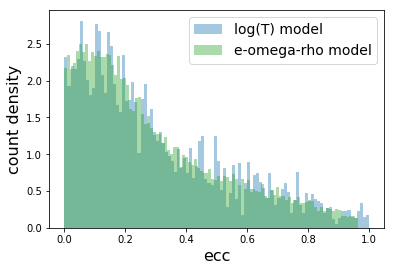

In [4]:
weights, ecc, omega = imp_sample(rho_samples_mcmc, RHO_OBS)

plt.figure()
plt.hist(ecc, weights=weights, bins=100, density=True, alpha=0.4, label='log(T) model')
plt.hist(trace_EW['ecc'], bins=100, density=True, alpha=0.4, label='e-omega-rho model', color='C2')
plt.ylabel('count density', fontsize=16)
plt.xlabel('ecc', fontsize=16)
plt.legend(fontsize=14)
plt.show()

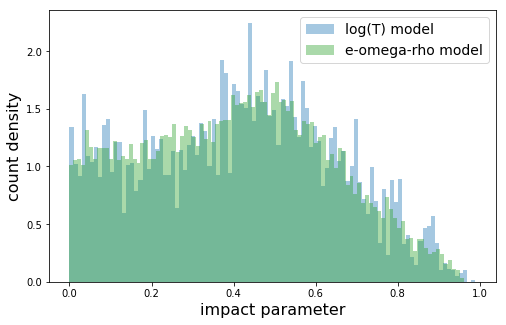

In [5]:
plt.figure(figsize=(8,5))
plt.hist(trace_S["b"], weights=weights, bins=100, density=True, alpha=0.4, label='log(T) model')
plt.hist(trace_EW['b'], bins=100, density=True, alpha=0.4, label='e-omega-rho model', color='C2')
plt.ylabel('count density', fontsize=16)
plt.xlabel('impact parameter', fontsize=16)
plt.legend(fontsize=14)
plt.show()

# Here's our more sophisticated ESS-based sampling scheme

The basic idea is to draw $\tilde{\rho}$ samples using a KDE oversampling approach, then importance sample $e$ and $\omega$. We wish to draw enough samples so that there is minimal loss of information content. There are two factors that go into this:
1. For unweighted samples, we must upsample by a factor of 3 to retain ~95% of information; this is so that each original sample has a ~95% chance of being drawn at least once.
2. Samples are weighted, so the ESS of importance sampling will be lower than for unweighted sampling. The contribution of weights to ESS can be determined by $1/\sum w^2$. For efficiency, we only retain samples which contribute $\delta_{\rm ESS} > 0.1$.

In [6]:
# estimate KDE bandwidth -- only needs to be done once
bw = get_bw(rho_samples_mcmc)
print(bw)

0.0523395925919915


In [7]:
samples = {}
samples["rho"] = np.array([])
samples["ecc"] = np.array([])
samples["omega"] = np.array([])
samples["ln_weights"] = np.array([])

n_up = np.min([int(5e4),10*len(rho_samples_mcmc)])
f_eff = ess_mcmc/len(rho_samples_mcmc)

ess_imp = 0
d_ess_lim = 0.1

run_num = 0
run_lim = 20

upsample_factor = 1

while ess_imp < upsample_factor*len(rho_samples_mcmc):
    run_num += 1
    if run_num > run_lim:
        print('Run limit ({0} runs) exceeded!'.format(run_lim))
        break
    else:
        print('RUN {0}'.format(run_num))
        print('drawing {0} synthetic samples'.format(n_up))

    # generate synthetic samples from actual MCMC samples with PDF oversampling
    rho = generate_synthetic_samples(rho_samples_mcmc.reshape(-1,1), [bw], n_up)[:,0]
    
    # use synthetic samples for importance sampling
    ln_weights, ecc, omega = imp_sample(rho, RHO_OBS, return_log=True)
    
    
    # combine new samples with samples from previous iterations
    rho = np.hstack([rho, samples["rho"]])
    ecc = np.hstack([ecc, samples["ecc"]])
    omega = np.hstack([omega, samples["omega"]])
    ln_weights = np.hstack([ln_weights, samples["ln_weights"]])
    
    weights = np.exp(ln_weights - np.max(ln_weights))
    w_norm = weights/np.sum(weights)
    
    # this is not the true ESS - it's the ESS if all synthetic data were uncorrelated
    # i.e. this only account for the importance weight contribution to reduced ESS
    ess_imp = 1 / np.sum(w_norm**2)

    # use leave-out-out to measure 'd_ess' for each sample as a measure of sample importance
    idx = np.arange(0, len(w_norm), dtype="int")
    ess_LOO = np.zeros(len(w_norm))
    
    for i, w in enumerate(w_norm):
        w_ = w_norm[idx != i]
        w_ /= np.sum(w_)
        ess_LOO[i] = 1/np.sum(w_**2)
        
    d_ess = ess_imp - ess_LOO
    
    # keep only samples with 'd_ess' above the limit 'd_ess_lim'
    keep = d_ess > d_ess_lim
    
    samples["rho"] = rho[keep]
    samples["ecc"] = ecc[keep]
    samples["omega"] = omega[keep]
    samples["weights"] = weights[keep]
    samples["ln_weights"] = ln_weights[keep]  # storing both weights and ln-weights is redundant but convenient
    
    print("keeping {0} samples (cumulative)\n".format(np.sum(keep)))
    
    # estimate how many more upsamples should be drawn
    if run_num == 1:
        w_ = samples["weights"]/np.sum(samples["weights"])
        ess_ = 1/np.sum(w_**2)
        
        efficiency = ess_/n_up
        estimated_upsamples_needed = int(upsample_factor*len(rho_samples_mcmc)/efficiency)
        cumulative_upsample_count = 0
        
        print("---")
        print("efficiency = {0:.3f}".format(efficiency))
        print("estimated upsamples to be drawn: {0}".format(estimated_upsamples_needed))
        print("---\n")
              
    cumulative_upsample_count += n_up
    
    # next iteration draw betweeen 1k-50k new synthetic upsamples
    n_up = np.max([1000, np.min([int(5e4), estimated_upsamples_needed-cumulative_upsample_count])])
    
    
print("\nOVERSAMPLING COMPLETE")

RUN 1
drawing 50000 synthetic samples
keeping 6874 samples (cumulative)

---
efficiency = 0.092
estimated upsamples to be drawn: 217118
---

RUN 2
drawing 50000 synthetic samples
keeping 13883 samples (cumulative)

RUN 3
drawing 50000 synthetic samples
keeping 20821 samples (cumulative)

RUN 4
drawing 50000 synthetic samples
keeping 27732 samples (cumulative)

RUN 5
drawing 17118 synthetic samples
keeping 30037 samples (cumulative)


OVERSAMPLING COMPLETE


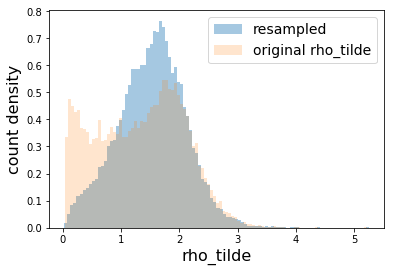

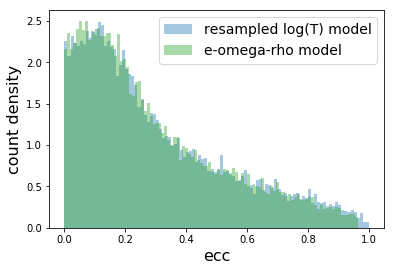

In [8]:
# plot new 'resampled' data vs. 'original' data from log(T) method results
plt.figure();
plt.hist(samples["rho"], bins=100, density=True, alpha=0.4, label='resampled');
plt.hist(rho_samples_mcmc.reshape(-1), bins=100, density=True, alpha=0.2, label='original rho_tilde');
plt.ylabel('count density', fontsize=16)
plt.xlabel('rho_tilde', fontsize=16)
plt.legend(fontsize=14);
plt.show();


# plot eccentricity distribution of new data with importance sampling vs. 
# empirical eccentricity distribution from e-omega-rho sampling
plt.figure();
plt.hist(samples["ecc"], weights=samples["weights"], bins=100, density=True, alpha=0.4, label='resampled log(T) model');
plt.hist(trace_EW['ecc'], bins=100, density=True, alpha=0.4, label='e-omega-rho model', color='C2');
plt.ylabel('count density', fontsize=16)
plt.xlabel('ecc', fontsize=16)
plt.legend(fontsize=14);
plt.show();

# Save oversampled data

In [ ]:
with open(MAINPATH + 'test_data/' + test + '_I.pkl', 'wb') as f:
    pickle.dump(samples, f)

# Q-Q and $\Delta e$ plots

In [ ]:
ecut = 0.95

ecc_ew = np.asarray(trace_EW["ecc"][trace_EW["ecc"] < ecut])
ecc_T = samples["ecc"][samples["ecc"] < ecut]
w_T = samples["weights"][samples["ecc"] < ecut]
w_T /= np.sum(w_T)

percs = np.arange(100.)
perc_ew = np.zeros_like(percs)
perc_T = np.zeros_like(percs)

for i, p in enumerate(percs):
    perc_ew[i] =  np.percentile(ecc_ew, p)
    perc_T[i] = weighted_percentile(ecc_T, p, w_T)
    
perc_ew = boxcar_smooth(perc_ew, 5)
perc_T = boxcar_smooth(perc_T, 5)
    
plt.figure()
plt.plot(percs, perc_T-perc_ew, "k")
plt.xlabel("percentile", fontsize=24)
plt.ylabel(r"$e_T - e_{e\omega\rho}$", fontsize=24)
plt.show()

In [ ]:
q_ew = np.array([stats.percentileofscore(ecc_ew, p, 'rank') for p in perc_ew])
q_T = np.array([stats.percentileofscore(ecc_ew, p, 'rank') for p in perc_T])

plt.figure(figsize=(8,8))
plt.plot(q_ew, q_T, "ko")
plt.plot(np.linspace(0,100), np.linspace(0,100), "r", lw=3)
plt.xlabel(r"$e_{e\omega\rho}$ percentile", fontsize=24)
plt.ylabel(r"$e_T$ percentile", fontsize=24)
plt.show()

# Bootstrap KS/AD test

### First check $\{e, \omega\}$ against itself

In [ ]:
Nboot = 1000
KS_boot = np.zeros(Nboot)
AD_boot = np.zeros(Nboot)

for i in range(Nboot):
    if i % 100 == 0: print(i)
        
    ecc_boot = np.random.choice(ecc_ew, size=len(ecc_ew), replace=True)
    
    KS_boot[i] = stats.ks_2samp(ecc_ew, ecc_boot)[1]
    AD_boot[i] = anderson_2samp(ecc_ew, ecc_boot)[1]
    
    
plt.figure(figsize=(8,5))
plt.hist(np.log10(KS_boot), bins=np.linspace(-1.5,0,16), alpha=0.4, label="KS")
plt.hist(np.log10(AD_boot), bins=np.linspace(-1.5,0,16), alpha=0.4, label="AD")
plt.xlabel(r"$\log_{10}p$", fontsize=20)
plt.ylabel("counts", fontsize=20)
plt.legend(fontsize=16)
plt.title(r"Comparing $e_{e\omega\rho}$ against itself", fontsize=24)
plt.show()

### Now check $\{e, \omega\}$ against $\log T$

In [ ]:
Nboot = 1000
KS_boot = np.zeros(Nboot)
AD_boot = np.zeros(Nboot)

for i in range(Nboot):
    if i % 100 == 0: print(i)
        
    ecc_boot = np.random.choice(ecc_T, size=len(ecc_T), p=w_T, replace=True)
    
    KS_boot[i] = stats.ks_2samp(ecc_ew, ecc_boot)[1]
    AD_boot[i] = anderson_2samp(ecc_ew, ecc_boot)[1]
    
    
plt.figure(figsize=(8,5))
plt.hist(np.log10(KS_boot), bins=np.linspace(-8,0,17), alpha=0.4, label="KS")
plt.hist(np.log10(AD_boot), bins=np.linspace(-8,0,17), alpha=0.4, label="AD")
plt.xlabel(r"$\log_{10}p$", fontsize=20)
plt.ylabel("counts", fontsize=20)
plt.legend(fontsize=16)
plt.title(r"$e_{e\omega\rho}$ against $e_{T}$", fontsize=24)
plt.show()